In [2]:
# Processing libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
import random
import seaborn as sns
import pandas_ta as ta
import plotly.graph_objects as go
from scipy import stats
from backtesting import Backtest, Strategy
import seaborn as sns
from backtesting.lib import TrailingStrategy

In [3]:
df = pd.read_csv('../data/gmedata.csv')

# Preprocessing
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df.sort_values(by='Date', ascending=True)
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2020-03-16,3.93,4.57,3.90,4.37,"4,866,696"
2020-03-17,4.40,4.65,4.11,4.23,"3,562,210"
2020-03-18,4.10,4.25,3.50,3.77,"3,651,709"
2020-03-19,3.71,4.20,3.55,4.19,"5,039,539"
2020-03-20,4.08,4.08,3.65,3.76,"7,722,194"


In [3]:
# SMA Low and SMA High
sma_low = ta.sma(df["Close"], 50)
sma_high = ta.sma(df["Close"], 100)

df["SMA_Low"] = sma_low
df["SMA_High"] = sma_high

df.tail()

,Open,High,Low,Close,Volume,SMA_Low,SMA_High
Date,,,,,,,
2021-03-08,154.89,210.87,146.10,194.5,"63,565,621",76.3792,44.9623
2021-03-09,217.71,249.85,208.51,246.9,"39,099,328",80.9058,47.3125
2021-03-10,269.43,348.50,172.00,265.0,"71,570,570",85.8028,49.8400
2021-03-11,241.64,281.50,232.60,260.0,"28,312,490",90.5830,52.3017
2021-03-12,275.00,295.50,262.27,264.5,"25,845,900",95.4854,54.8136


In [4]:
fig = go.Figure()
fig.add_trace(go.Candlestick(
    x=df.index,
    open=df['Open'],
    high=df['High'],
    low=df['Low'],
    close=df['Close'],
    name='Candlesticks'
))
fig.add_trace(go.Scatter(
    x=df.index,
    y=df['SMA_Low'],
    line=dict(color='blue'),
    name='SMA_Low'
))
fig.add_trace(go.Scatter(
    x=df.index,
    y=df['SMA_High'],
    line=dict(color='orange'),
    name='SMA_High'
))
fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Price',
    xaxis_rangeslider_visible=False
)
fig.show()

In [5]:
def sma_signal():
    signal = [0] * len(df)
    for row in range(0, len(df)):
        if (df.iloc[row-1].SMA_Low > df.iloc[row-1].SMA_High and df.iloc[row-2].SMA_Low < df.iloc[row-2].SMA_High):
            signal[row] = 1 #long
        if (df.iloc[row-1].SMA_Low < df.iloc[row-1].SMA_High and df.iloc[row-2].SMA_Low > df.iloc[row-2].SMA_High):
            signal[row] = 2 #short

    df['Signal'] = signal
    return signal

sma_signal()
df[df['Signal']!=0]

,Open,High,Low,Close,Volume,SMA_Low,SMA_High,Signal
Date,,,,,,,,
2020-09-09,7.96,7.99,7.31,7.35,"9,068,082",4.829,4.7927,1


In [6]:
class MyStrat(Strategy):
    mysize = 0.1
    sma_low_len = 50
    sma_high_len = 100

    def init(self):
        super().init()
        df["SMA_Low"] = ta.sma(df.Close, length=self.sma_low_len) 
        df["SMA_High"] = ta.sma(df.Close, length=self.sma_high_len) 
        self.signal = self.I(sma_signal)

    def next(self):
        super().next()
        if self.signal == 1:
            self.buy()
        elif self.signal == 2: 
            self.sell()

bt = Backtest(df, MyStrat, cash=100000, margin=1, commission=.000)
stat = bt.run()
stat

Start                     2020-03-16 00:00:00
End                       2021-03-12 00:00:00
Duration                    361 days 00:00:00
Exposure Time [%]                    50.59761
Equity Final [$]                   4135178.95
Equity Peak [$]                    5225511.82
Return [%]                         4035.17895
Buy & Hold Return [%]             5952.631579
Return (Ann.) [%]                 4096.957049
Volatility (Ann.) [%]           108282.914425
Sharpe Ratio                         0.037836
Sortino Ratio                         40.0713
Calmar Ratio                        46.387809
Max. Drawdown [%]                  -88.319694
Avg. Drawdown [%]                  -15.411288
Max. Drawdown Duration       44 days 00:00:00
Avg. Drawdown Duration       12 days 00:00:00
# Trades                                    1
Win Rate [%]                            100.0
Best Trade [%]                    4035.338346
Worst Trade [%]                   4035.338346
Avg. Trade [%]                    

  0%|          | 0/13 [00:00<?, ?it/s]

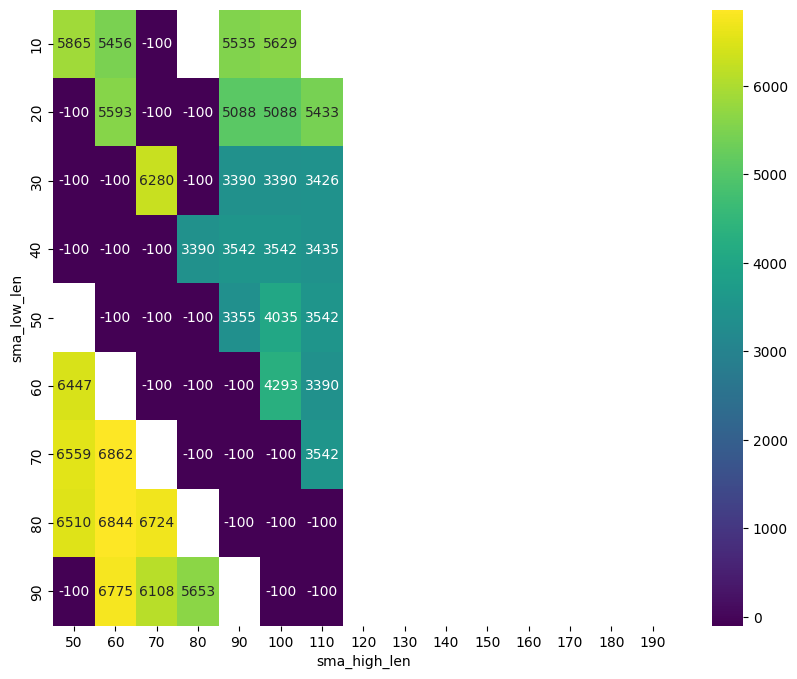

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Backtest optimization
bt = Backtest(df, MyStrat, cash=100000, margin=1, commission=.000)
stats, heatmap = bt.optimize(
                    sma_low_len = range(10,100,10),
                    sma_high_len = range(50,200,10),
                    maximize='Return [%]', max_tries=400,
                    random_state=0,
                    return_heatmap=True)
stats

# Convert multiindex series to dataframe
heatmap_df = heatmap.unstack()
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_df, annot=True, cmap='viridis', fmt='.0f')
plt.show()